In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import hashlib
import random
import shutil
import Augmentor
from google.colab import drive


# Load the raw Data

In [4]:
import zipfile

#Unzip the downloaded file

zip_ref=zipfile.ZipFile('/content/drive/MyDrive/Major_Project/Face_recognition/Employee_face_drawn.zip','r')
zip_ref.extractall()
zip_ref.close()

In [5]:
!ls Employee_face_drawn

test  train


In [6]:
!ls Employee_face_drawn/train/

o007  r059   r322  r445  r480  r519  r557  r588  r611  r631  r651  r676  r696
o011  r1001  r329  r447  r481  r520  r558  r591  r612  r632  r652  r677  r697
o016  r1003  r368  r448  r483  r524  r559  r592  r613  r633  r653  r678  r698
o018  r1007  r379  r449  r485  r525  r561  r593  r614  r634  r654  r679  r699
o021  r144   r383  r450  r486  r527  r563  r594  r615  r635  r655  r680  r700
o025  r153   r384  r451  r489  r528  r564  r595  r616  r636  r656  r681  r701
o029  r161   r385  r452  r490  r529  r565  r596  r617  r637  r657  r682  r702
o035  r189   r388  r453  r491  r534  r566  r597  r618  r638  r658  r683  r704
o036  r199   r389  r455  r492  r536  r569  r598  r619  r639  r659  r684  r705
o037  r231   r410  r459  r493  r537  r570  r599  r620  r640  r660  r685  r707
o043  r251   r411  r461  r494  r538  r575  r600  r621  r641  r661  r686  r708
o045  r260   r412  r462  r501  r539  r576  r601  r622  r642  r665  r687  r709
o064  r288   r414  r466  r502  r540  r577  r603  r623  r643  r66

In [23]:
#data frame create

def create_image_count_dataframe(directory):
    folder_names = []
    image_counts = []
    skip_first = True

    for root, dirs, files in os.walk(directory):
        if skip_first:
            skip_first = False
            continue

        image_count = len([file for file in files if file.endswith(('.jpg', '.jpeg', '.png',))])
        folder_name = os.path.basename(root)
        folder_names.append(folder_name)
        image_counts.append(image_count)

    # Creating the DataFrame
    data = {'Subfolder': folder_names, 'Image Count': image_counts}
    df = pd.DataFrame(data)

    return df

# Replace 'directory_path' with the actual path to your directory
directory_path = '/content/Employee_face_drawn/train'
df = create_image_count_dataframe(directory_path)
print(df)


    Subfolder  Image Count
0        r648           21
1        r388           21
2        o066           21
3        r302           21
4        r578           21
..        ...          ...
251      r308           21
252      r619           21
253      r452           21
254      r647           21
255      r653           21

[256 rows x 2 columns]


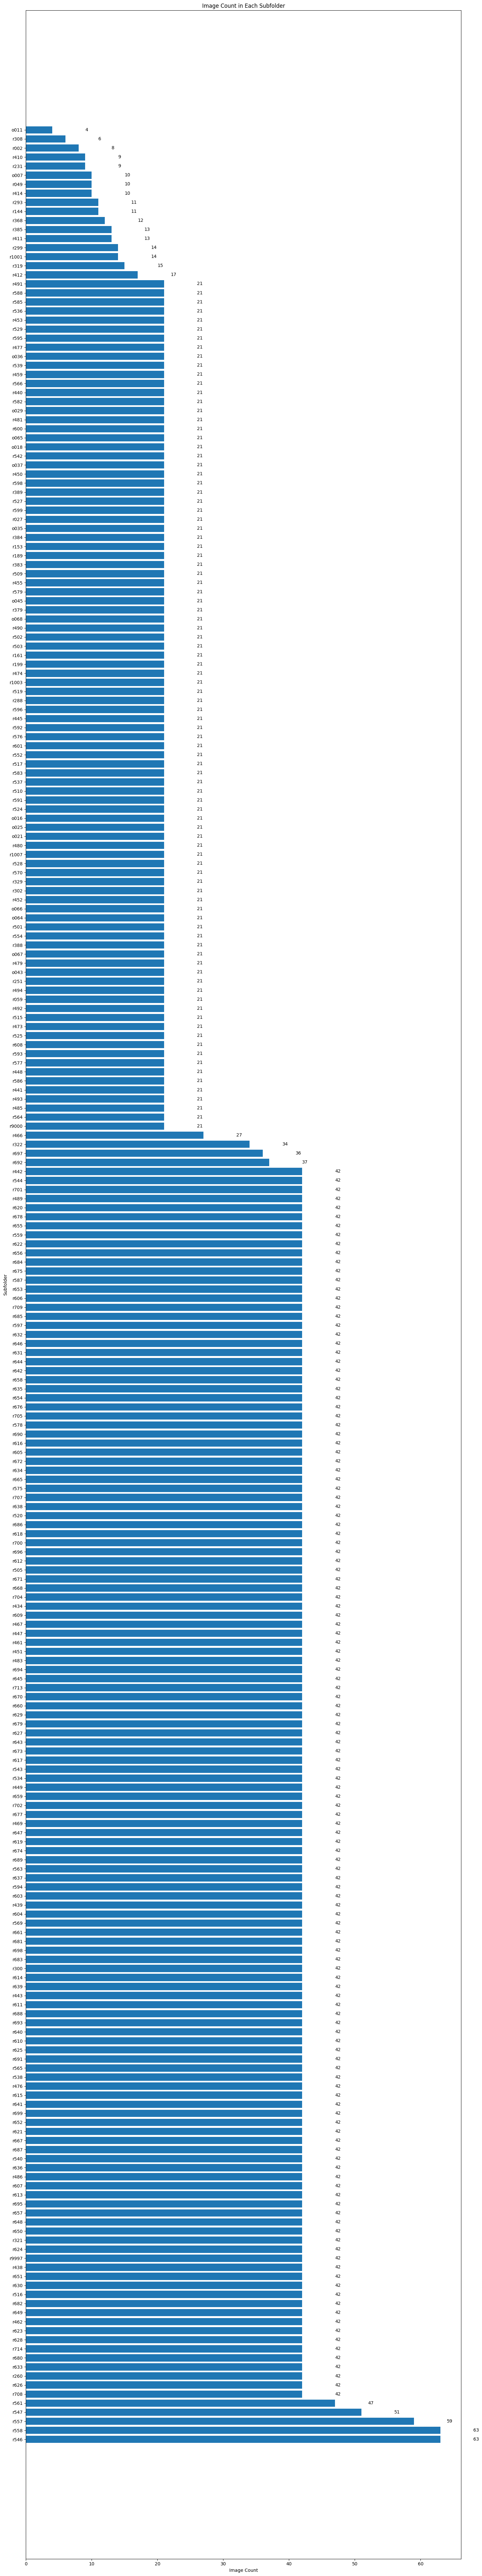

In [8]:
# Sort the DataFrame by image count in descending order
df = df.sort_values(by='Image Count', ascending=False)

# Plotting the data as a horizontal bar chart
plt.figure(figsize=(15, 80))
plt.barh(df['Subfolder'], df['Image Count'])
plt.xlabel('Image Count')
plt.ylabel('Subfolder')
plt.title('Image Count in Each Subfolder')

# Adding value labels on the bars
for i, count in enumerate(df['Image Count']):
    plt.text(count + 5, i, str(count), ha='left', va='center')

plt.tight_layout()
plt.show()

In [9]:
count_21_images = len(df[df['Image Count'] == 21])
print("Number of folders with 21 images:", count_21_images)

Number of folders with 21 images: 94


In [10]:
count_42_images = len(df[df['Image Count'] == 42])
print("Number of folders with 42 images:", count_42_images)

Number of folders with 42 images: 136


In [11]:
#which folder have more than 21 images first unique image choose and then give priority to other variation and sampling them and remaining image remove

def select_random_images(directory, target_count):
    for root, dirs, files in os.walk(directory):
        if len(files) > target_count:
            images = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
            unique_images = list(set(images))
            duplicate_images = list(set(images) - set(unique_images))

            selected_images = []
            if len(unique_images) >= target_count:
                selected_images.extend(random.sample(unique_images, target_count))
            else:
                selected_images.extend(unique_images)
                duplicate_count = target_count - len(unique_images)
                selected_images.extend(random.sample(duplicate_images, duplicate_count))

            for file in files:
                file_path = os.path.join(root, file)
                if file not in selected_images:
                    os.remove(file_path)

# Replace 'directory_path' with the actual path to your directory
directory_path = '/content/Employee_face_drawn/train/'
target_count = 21  # Specify the desired number of images per folder

select_random_images(directory_path, target_count)


In [12]:
new_df = create_image_count_dataframe(directory_path)
print(new_df)

    Subfolder  Image Count
0        r648           21
1        r388           21
2        o066           21
3        r302           21
4        r578           21
..        ...          ...
251      r308            6
252      r619           21
253      r452           21
254      r647           21
255      r653           21

[256 rows x 2 columns]


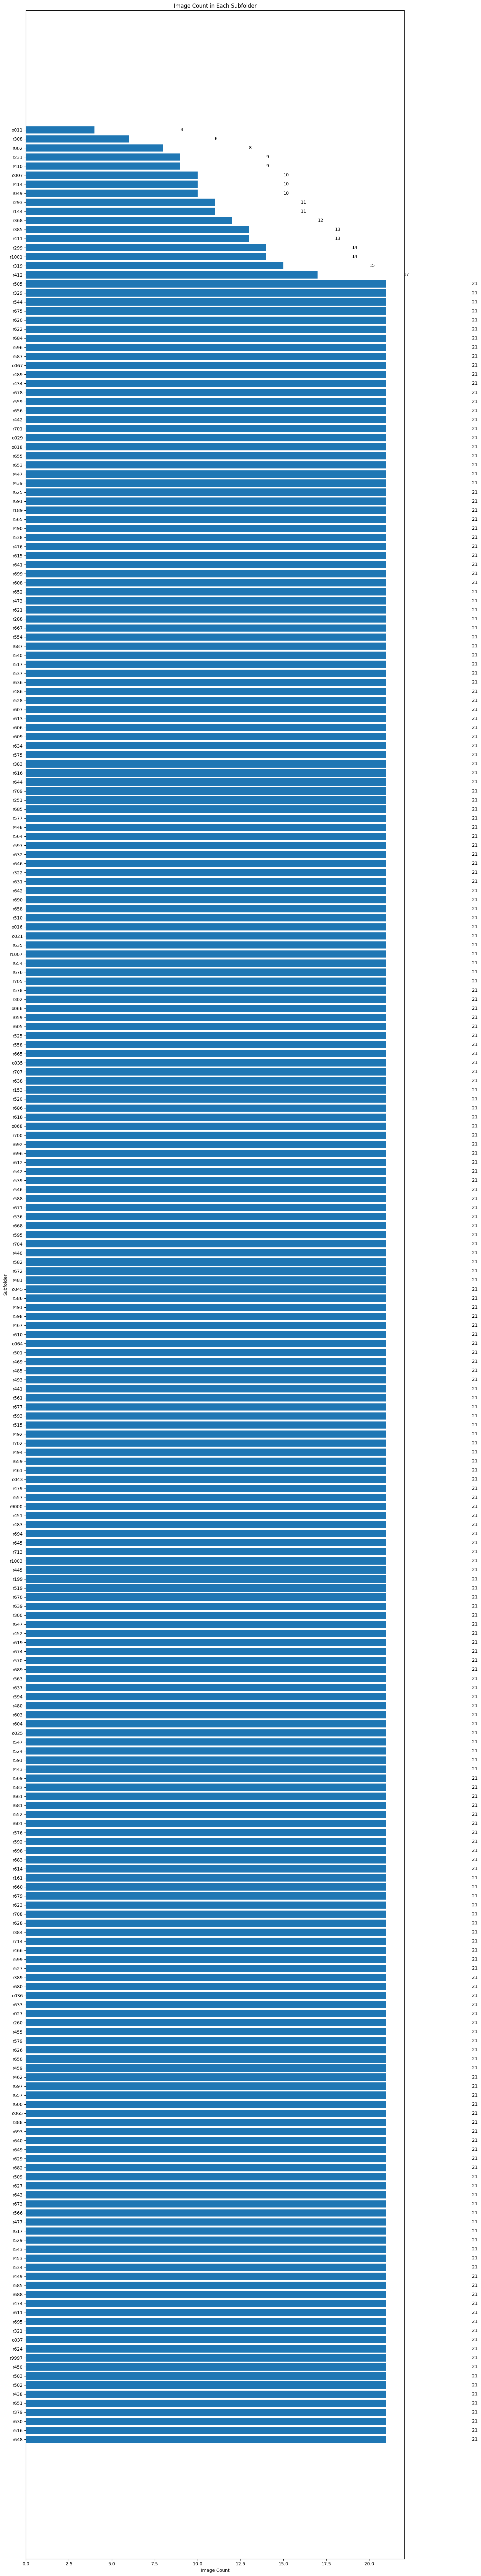

In [13]:
# Sort the DataFrame by image count in descending order
new_df = new_df.sort_values(by='Image Count', ascending=False)

# Plotting the data as a horizontal bar chart
plt.figure(figsize=(15, 80))
plt.barh(new_df['Subfolder'], new_df['Image Count'])
plt.xlabel('Image Count')
plt.ylabel('Subfolder')
plt.title('Image Count in Each Subfolder')

# Adding value labels on the bars
for i, count in enumerate(new_df['Image Count']):
    plt.text(count + 5, i, str(count), ha='left', va='center')

plt.tight_layout()
plt.show()

In [14]:
count_21_images_new = len(new_df[new_df['Image Count'] == 21])
print("Number of folders with 21 images:", count_21_images_new)

Number of folders with 21 images: 239


In [16]:
#which folder have less than 21 images augment images and try to make it 21 images in each folder.

def augment_folders(directory, target_count):
    for root, dirs, files in os.walk(directory):
        if len(files) > 0:
            folder_path = os.path.join(root)
            num_existing = len(files)
            num_augmented = target_count - num_existing

            # Check if augmentation is needed
            if num_augmented > 0:
                p = Augmentor.Pipeline(folder_path, output_directory=folder_path)
                
                # Add augmentation operations to the pipeline
                p.random_contrast(probability=0.8, min_factor=0.8, max_factor=1.2)  # Random contrast adjustment
                p.random_brightness(probability=0.8, min_factor=0.8, max_factor=1.2)  # Random brightness adjustment
                p.random_color(probability=0.8, min_factor=0.8, max_factor=1.2)  # Random color adjustment
                p.random_erasing(probability=0.2, rectangle_area=0.2)  # Random erasing

                p.sample(num_augmented)

# Replace 'directory_path' with the actual path to your directory
directory_path = '/content/Employee_face_drawn/train/'
target_count = 21  # Specify the desired number of images per folder

augment_folders(directory_path, target_count)


Initialised with 10 image(s) found.
Output directory set to /content/Employee_face_drawn/train/o007.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AFFA30>: 100%|██████████| 11/11 [00:00<00:00, 33.52 Samples/s]


Initialised with 13 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r385.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AFF700>: 100%|██████████| 8/8 [00:00<00:00, 31.28 Samples/s]


Initialised with 14 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r299.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AF1AB0>: 100%|██████████| 7/7 [00:00<00:00, 29.20 Samples/s]


Initialised with 15 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r319.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AF21A0>: 100%|██████████| 6/6 [00:00<00:00, 33.18 Samples/s]


Initialised with 11 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r144.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AF3280>: 100%|██████████| 10/10 [00:00<00:00, 33.29 Samples/s]


Initialised with 4 image(s) found.
Output directory set to /content/Employee_face_drawn/train/o011.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F859E5EF010>: 100%|██████████| 17/17 [00:00<00:00, 36.62 Samples/s]


Initialised with 9 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r410.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AFF5B0>: 100%|██████████| 12/12 [00:00<00:00, 47.11 Samples/s]


Initialised with 10 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r414.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A1000>: 100%|██████████| 11/11 [00:00<00:00, 53.46 Samples/s]


Initialised with 10 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r049.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AFE770>: 100%|██████████| 11/11 [00:00<00:00, 44.10 Samples/s]


Initialised with 9 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r231.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AFF9D0>: 100%|██████████| 12/12 [00:00<00:00, 44.99 Samples/s]


Initialised with 12 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r368.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A1AFF9D0>: 100%|██████████| 9/9 [00:00<00:00, 53.22 Samples/s]


Initialised with 14 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r1001.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A36A0>: 100%|██████████| 7/7 [00:00<00:00, 48.55 Samples/s]


Initialised with 17 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r412.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A2C80>: 100%|██████████| 4/4 [00:00<00:00, 50.16 Samples/s]


Initialised with 11 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r293.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A1CC0>: 100%|██████████| 10/10 [00:00<00:00, 51.26 Samples/s]


Initialised with 8 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r002.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A3B20>: 100%|██████████| 13/13 [00:00<00:00, 47.96 Samples/s]


Initialised with 13 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r411.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A35B0>: 100%|██████████| 8/8 [00:00<00:00, 52.88 Samples/s]


Initialised with 6 image(s) found.
Output directory set to /content/Employee_face_drawn/train/r308.

Processing <PIL.Image.Image image mode=RGB size=640x360 at 0x7F85A19A2050>: 100%|██████████| 15/15 [00:00<00:00, 44.81 Samples/s]


In [17]:
new_df_2 = create_image_count_dataframe(directory_path)
print(new_df_2)

    Subfolder  Image Count
0        r648           21
1        r388           21
2        o066           21
3        r302           21
4        r578           21
..        ...          ...
251      r308           21
252      r619           21
253      r452           21
254      r647           21
255      r653           21

[256 rows x 2 columns]


In [19]:
count_21_images_new_2 = len(new_df_2[new_df_2['Image Count'] == 21])
print("Number of folders with 21 images:", count_21_images_new_2)

Number of folders with 21 images: 256


In [ ]:
#make this data's zip file and upload to drive.

def create_zip_folder(folder_path, zip_file_name, drive_save_path):
    # Create a new zip file
    with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Iterate over all the files in the folder
        for root, _, files in os.walk(folder_path):
            for file in files:
                # Get the full path of the file
                file_path = os.path.join(root, file)
                
                # Add the file to the zip file
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the destination path in Google Drive
    save_path = os.path.join(drive_save_path, zip_file_name)

    # Move the zip file to Google Drive
    shutil.move(zip_file_name, save_path)

    print(f"Zip file '{zip_file_name}' saved in Google Drive at '{save_path}'.")

# Specify the folder path, zip file name, and Google Drive save path
folder_path = '/content/Employee_face_drawn/train'
zip_file_name = '21_emp_data_each.zip'
drive_save_path = '/content/drive/MyDrive/Major_Project/Face_recognition'

# Call the function to create the zip file and save it in Google Drive
create_zip_folder(folder_path, zip_file_name, drive_save_path)
